# Capstone Final Project - Week 1

## Problem Description

Where is the best location to establish a new halal restaurant in NY City?

## Background

There are approximately 700,000 Muslims in NY City.  Practicing Muslims adhere to 'halal' dietary restrictions.  The word 'halal' in arabic translates casually as 'acceptable'.  A more formal extension of the 'halal' definition is 'zabiha-halal' which is meat that has been hand-slaughtered with delicate precision in an ethical manner meant to minimize suffering for the animal and according to the religious teachings of Muslim beliefs.  In other belief systems 'halal' is also known as 'kosher'.  Since a majority of delis, restaurants, and franchises do not observe these requirements by default, this severely limits the options available for the 'halal' consumer.  In this project, we'll analyze possible locations in NYC to establish a new halal restaurant catering to the 'halal' demographic based on existing demand and popularity found in our data set.

## Data

Our primary dataset sources used to analyze this problem include:

- https://cocl.us/new_york_dataset
    - Used to capture and filter NYC district neighborhoods and borough information


- Foursquare API
    - Used to query, sort, and rank relevant venue data in the area.


The two sets of data will be analyzed, integrated, overlayed, and visualized to determine potential solutions to our problem.

# Capstone Final Project - Week 2 - Code

## Methodology

In [1]:
#Install Libraries

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium
import os
import folium # map rendering library

# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.11.0              |             py_0          61 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.4.1-py_0        conda-forge
    folium:          

## Get City and Venue data respectively in NYC

In [3]:
#NYC Data from FourSquare

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [66]:
#Top 100 results within 1000 metres from lat-Lon

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'D2PD3BA1FC3LCI0O4O4ZHNIWWXJVDWDAYUQI2SBKDAN4JRQ2'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='4NFCXGQLG5DQPSQGUBJHXA5AEAV2HMKUSM0YMS1Z1QNNDIYD' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20200905' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [67]:
#Get Venue Details for Rankings

def get_venue_details(venue_id):
        
    CLIENT_ID = 'D2PD3BA1FC3LCI0O4O4ZHNIWWXJVDWDAYUQI2SBKDAN4JRQ2'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='4NFCXGQLG5DQPSQGUBJHXA5AEAV2HMKUSM0YMS1Z1QNNDIYD' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20200905' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [68]:
#Define NYC function with location data

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [69]:
# get NY Data
new_york_data=get_new_york_data()
new_york_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [70]:
new_york_data.shape

(306, 4)

## Analyze Potential Site Locations by Boroughs

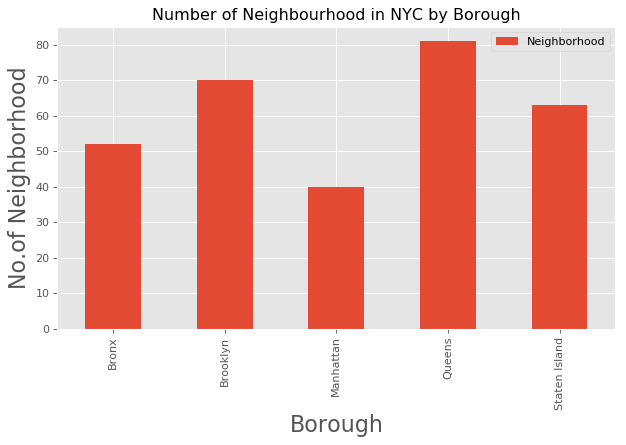

In [71]:
#Total Neighborhoods in NYC by Borough

from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 20)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=20)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

## Query Existing Halal Restaurant Locations in NYC

In [173]:
# Find neighborhoods with Halal restaurant

column_names=['Borough', 'Neighborhood', 'ID','Name']
halal_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    halal_resturants=venues[venues['Category']=='Halal Restaurant']   
    print('(',count,'/',len(new_york_data),')','Halal Resturants in '+Neighborhood+', '+Borough+':'+str(len(halal_resturants)))
    for resturant_detail in halal_resturants.values.tolist():
        id, name , category=resturant_detail
        halal_rest_ny = halal_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Halal Resturants in Wakefield, Bronx:0
( 2 / 306 ) Halal Resturants in Co-op City, Bronx:0
( 3 / 306 ) Halal Resturants in Eastchester, Bronx:0
( 4 / 306 ) Halal Resturants in Fieldston, Bronx:0
( 5 / 306 ) Halal Resturants in Riverdale, Bronx:0
( 6 / 306 ) Halal Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Halal Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Halal Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Halal Resturants in Norwood, Bronx:0
( 10 / 306 ) Halal Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Halal Resturants in Baychester, Bronx:0
( 12 / 306 ) Halal Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Halal Resturants in City Island, Bronx:0
( 14 / 306 ) Halal Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Halal Resturants in University Heights, Bronx:0
( 16 / 306 ) Halal Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Halal Resturants in Fordham, Bronx:0
( 18 / 306 ) Halal Resturants in East Tremont, Bronx:0
( 19 / 306 ) Halal Resturants in W

( 146 / 306 ) Halal Resturants in Rego Park, Queens:0
( 147 / 306 ) Halal Resturants in Woodhaven, Queens:0
( 148 / 306 ) Halal Resturants in Ozone Park, Queens:0
( 149 / 306 ) Halal Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Halal Resturants in College Point, Queens:0
( 151 / 306 ) Halal Resturants in Whitestone, Queens:0
( 152 / 306 ) Halal Resturants in Bayside, Queens:0
( 153 / 306 ) Halal Resturants in Auburndale, Queens:0
( 154 / 306 ) Halal Resturants in Little Neck, Queens:0
( 155 / 306 ) Halal Resturants in Douglaston, Queens:0
( 156 / 306 ) Halal Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Halal Resturants in Bellerose, Queens:1
( 158 / 306 ) Halal Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Halal Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Halal Resturants in Briarwood, Queens:0
( 161 / 306 ) Halal Resturants in Jamaica Center, Queens:1
( 162 / 306 ) Halal Resturants in Oakland Gardens, Queens:0
( 163 / 306 ) Halal Resturants in Queens Vil

( 285 / 306 ) Halal Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Halal Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Halal Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Halal Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Halal Resturants in Roxbury, Queens:0
( 290 / 306 ) Halal Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Halal Resturants in Middle Village, Queens:0
( 292 / 306 ) Halal Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Halal Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Halal Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Halal Resturants in Malba, Queens:0
( 296 / 306 ) Halal Resturants in Highland Park, Brooklyn:0
( 297 / 306 ) Halal Resturants in Madison, Brooklyn:0
( 298 / 306 ) Halal Resturants in Bronxdale, Bronx:0
( 299 / 306 ) Halal Resturants in Allerton, Bronx:0
( 300 / 306 ) Halal Resturants in Kingsbridge Heights, Bronx:0
( 301 / 306 ) Halal Resturants in Erasmus, Brook

In [174]:
halal_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bay Ridge,55a88497498ee3c7364c0d21,Istanbul Kitchen
1,Brooklyn,Manhattan Terrace,562828f2498ea6b65c7a257c,Affy's Premium Grill
2,Brooklyn,Flatbush,5b5fd2872632ec002c907cda,Jalsa - Grill And Gravy
3,Brooklyn,Dyker Heights,55a88497498ee3c7364c0d21,Istanbul Kitchen
4,Brooklyn,Ocean Parkway,562828f2498ea6b65c7a257c,Affy's Premium Grill


In [175]:
halal_rest_ny.shape

(16, 4)

## Sort Halal restaurant site locations by borough

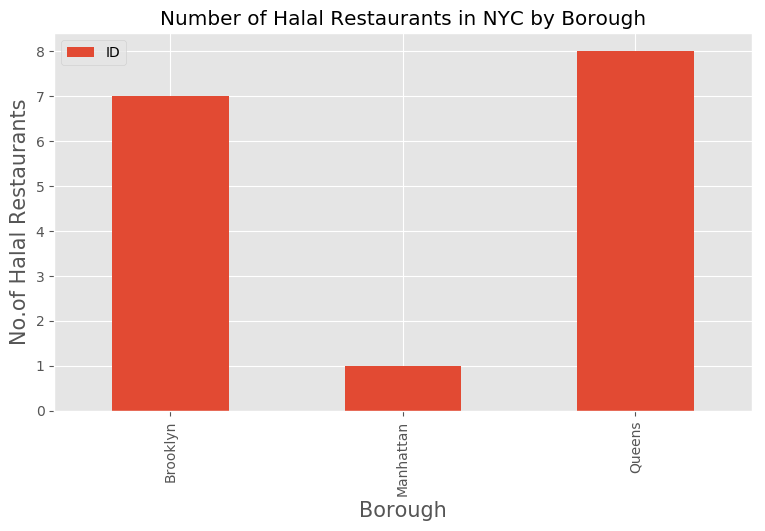

In [176]:
#Halal Restaurants in NYC by Borough

from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Halal Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Halal Restaurants', fontsize=15)
#giving a bar plot
halal_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [177]:
halal_rest_ny[halal_rest_ny['Neighborhood']=='Jamaica Hills']

,Borough,Neighborhood,ID,Name
11,Queens,Jamaica Hills,4f63e9e3e4b087553c66fc74,King Kabab
12,Queens,Jamaica Hills,53895cc5498e34b97acd9457,shahs halal cart


## Sort Halal restaurant locations by individual neighborhoods

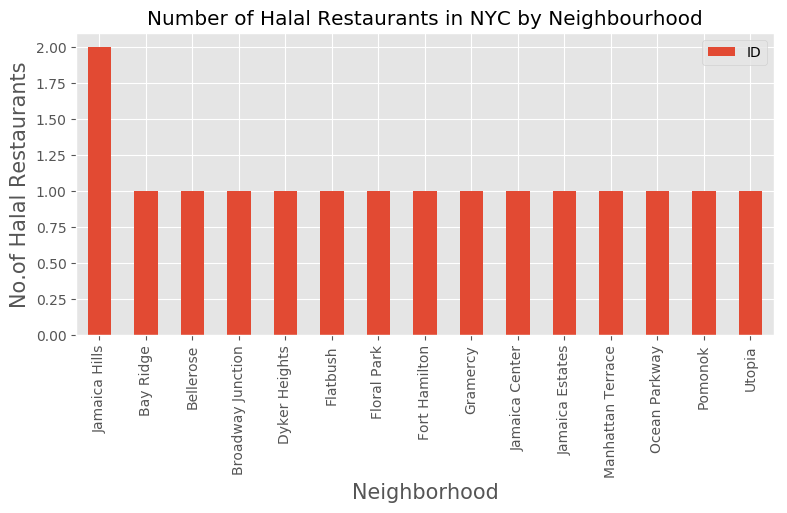

In [178]:
#Halal Restaurants by Neighrborhood

from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,4), dpi = 100)
# title
plt.title('Number of Halal Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Halal Restaurants', fontsize=15)
#giving a bar plot
halal_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(16).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## Analyze ratings for halal restuarant query

In [179]:
for row in halal_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

# prepare neighborhood list that contains halal resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
halal_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in halal_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(halal_rest_ny),')','processed')
    halal_rest_stats_ny = halal_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID              Name  Likes  Rating  Tips
0  55a88497498ee3c7364c0d21  Istanbul Kitchen      8     7.6     3
( 1 / 16 ) processed
                         ID                  Name  Likes  Rating  Tips
0  562828f2498ea6b65c7a257c  Affy's Premium Grill     12     7.6     5
( 2 / 16 ) processed
                         ID                     Name  Likes  Rating  Tips
0  5b5fd2872632ec002c907cda  Jalsa - Grill And Gravy      7     7.5     4
( 3 / 16 ) processed
                         ID              Name  Likes  Rating  Tips
0  55a88497498ee3c7364c0d21  Istanbul Kitchen      8     7.6     3
( 4 / 16 ) processed
                         ID                  Name  Likes  Rating  Tips
0  562828f2498ea6b65c7a257c  Affy's Premium Grill     12     7.6     5
( 5 / 16 ) processed
                         ID              Name  Likes  Rating  Tips
0  55a88497498ee3c7364c0d21  Istanbul Kitchen      8     7.6     3
( 6 / 16 ) processed
                         ID            N

In [180]:
halal_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,55a88497498ee3c7364c0d21,Istanbul Kitchen,8,7.6,3
1,Brooklyn,Manhattan Terrace,562828f2498ea6b65c7a257c,Affy's Premium Grill,12,7.6,5
2,Brooklyn,Flatbush,5b5fd2872632ec002c907cda,Jalsa - Grill And Gravy,7,7.5,4
3,Brooklyn,Dyker Heights,55a88497498ee3c7364c0d21,Istanbul Kitchen,8,7.6,3
4,Brooklyn,Ocean Parkway,562828f2498ea6b65c7a257c,Affy's Premium Grill,12,7.6,5


In [181]:
halal_rest_stats_ny.shape

(16, 7)

In [182]:
halal_rest_ny.shape

(16, 4)

In [183]:
halal_rest_stats_ny.to_csv('halal_rest_stats_ny.csv', index=False)

In [184]:
halal_rest_stats_ny_csv=pd.read_csv('halal_rest_stats_ny.csv')

In [185]:
halal_rest_stats_ny_csv.shape

(16, 7)

In [186]:
halal_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,55a88497498ee3c7364c0d21,Istanbul Kitchen,8,7.6,3
1,Brooklyn,Manhattan Terrace,562828f2498ea6b65c7a257c,Affy's Premium Grill,12,7.6,5
2,Brooklyn,Flatbush,5b5fd2872632ec002c907cda,Jalsa - Grill And Gravy,7,7.5,4
3,Brooklyn,Dyker Heights,55a88497498ee3c7364c0d21,Istanbul Kitchen,8,7.6,3
4,Brooklyn,Ocean Parkway,562828f2498ea6b65c7a257c,Affy's Premium Grill,12,7.6,5


In [187]:
halal_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
Borough         16 non-null object
Neighborhood    16 non-null object
ID              16 non-null object
Name            16 non-null object
Likes           16 non-null object
Rating          16 non-null float64
Tips            16 non-null object
dtypes: float64(1), object(6)
memory usage: 976.0+ bytes


In [188]:
halal_rest_stats_ny['Likes']=halal_rest_stats_ny['Likes'].astype('float64')

In [189]:
halal_rest_stats_ny['Tips']=halal_rest_stats_ny['Tips'].astype('float64')

In [190]:
halal_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
Borough         16 non-null object
Neighborhood    16 non-null object
ID              16 non-null object
Name            16 non-null object
Likes           16 non-null float64
Rating          16 non-null float64
Tips            16 non-null float64
dtypes: float64(3), object(4)
memory usage: 976.0+ bytes


## Analyze existing competition in 'halal' NY restaurant market

In [191]:
# Restaurants with maximum Likes
halal_rest_stats_ny.iloc[halal_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              523cc0df11d2ba091e493432
Name                      The Halal Guys
Likes                                689
Rating                               8.4
Tips                                 134
Name: 6, dtype: object

In [192]:
# Restaurants with maximum Rating
halal_rest_stats_ny.iloc[halal_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              523cc0df11d2ba091e493432
Name                      The Halal Guys
Likes                                689
Rating                               8.4
Tips                                 134
Name: 6, dtype: object

In [193]:
# Restaurants with maximum Tips
halal_rest_stats_ny.iloc[halal_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              523cc0df11d2ba091e493432
Name                      The Halal Guys
Likes                                689
Rating                               8.4
Tips                                 134
Name: 6, dtype: object

In [194]:
ny_neighborhood_stats=halal_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

## Sort potential site locations relative to strongest competition

In [143]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
7,Gramercy,8.40
0,Bay Ridge,7.60
3,Dyker Heights,7.60
6,Fort Hamilton,7.60
11,Manhattan Terrace,7.60
12,Ocean Parkway,7.60
4,Flatbush,7.50
8,Jamaica Center,7.30
10,Jamaica Hills,3.65
1,Bellerose,0.00


In [195]:
ny_borough_stats=halal_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [163]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.400
0,Brooklyn,6.500
2,Queens,1.825


## Results - Potential site locations based on demand and popularity of existing market


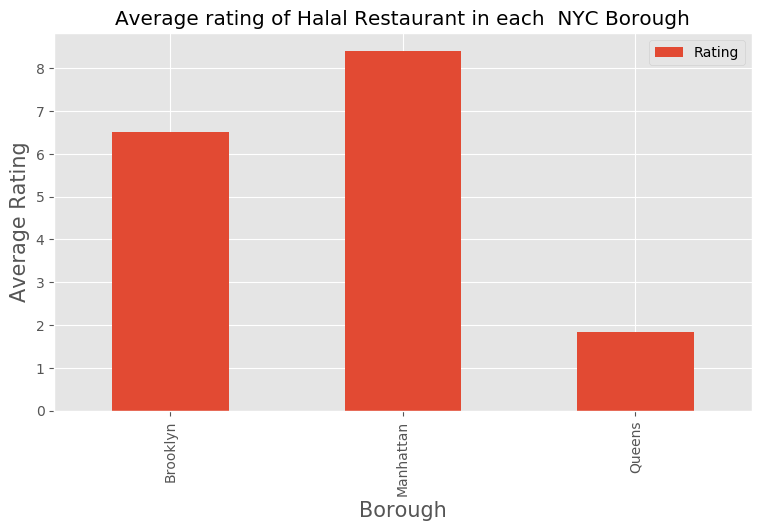

In [196]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Halal Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
halal_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [199]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.5]

In [200]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bay Ridge,7.6
3,Dyker Heights,7.6
4,Flatbush,7.5
6,Fort Hamilton,7.6
7,Gramercy,8.4
11,Manhattan Terrace,7.6
12,Ocean Parkway,7.6


In [201]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [202]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [203]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
4,Manhattan,Gramercy,40.737210,-73.981376,8.4
0,Brooklyn,Bay Ridge,40.625801,-74.030621,7.6
1,Brooklyn,Dyker Heights,40.619219,-74.019314,7.6
3,Brooklyn,Fort Hamilton,40.614768,-74.031979,7.6
5,Brooklyn,Manhattan Terrace,40.614433,-73.957438,7.6
6,Brooklyn,Ocean Parkway,40.613060,-73.968367,7.6
2,Brooklyn,Flatbush,40.636326,-73.958401,7.5


## Results - Visualize Potential Site Location

In [204]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [205]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [206]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [207]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Conclusion and Analysis


To summarize, our analysis yielded the following results:

- By volume, the market for 'halal' restaurants is centered around the borough of Brooklyn. 
    - Advantage: Existing demand already exists. 
    - Disadvantage: Over-concentration. May be difficult to penetrate existing market share.


- An alternate 'halal' location could be centered around the borough of Manhattan. An incumbent chain has garnered wild popularity, support, and is the highest rated model in the city by far.
    - Advantage: Less competition, opportunity for growth.
    - Disadvantage: Can be translated as more risk based on lack of chains.
 

## Recommendation

The recommended site location for the new 'halal' restaurant would be to compete in the Manhattan market alongside the incumbent.  While there is existing market potential in Brooklyn, there is more opportunity to piggyback off of success of incumbent franchise in Manhattan which has made a name for itself and create more supply to meet demand for 'halal' market at this location based on exceptional reviews.  It will allow new 'halal' restaurant to create some separation from the concentration in Brooklyn markets and offer consumers a contrast to existing Manhattan franchise.